In [1]:
import sys
import copy
import importlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('./')
import data_struct
from coord_utils import geo_util

In [3]:
importlib.reload(data_struct)
# importlib.reload(coord_utils)

<module 'data_struct' from '/Users/zhushuli/Projects.localized/PyCharm/IPIN22_Track6/data_struct.py'>

In [4]:
trace_posi_units = []

with open('./trials2023/POSI_testingData.txt', 'r') as fd:
    for line in fd:
        unit = data_struct.posiUnit(line.strip())
        trace_posi_units.append(unit)
    
print(len(trace_posi_units))

trace_posi_unit_map = {int(u.gps_tow): u for u in trace_posi_units}

5494


In [5]:
trace_sen_units = []

with open('./trials2023/mate20MeaDataRecorder_testingData.txt', 'r') as fd:
    for line in fd:
        if line.startswith('ACCE'):
            unit = data_struct.acceUnit(line.strip())
        elif line.startswith('GYRO'):
            unit = data_struct.gyroUnit(line.strip())
        elif line.startswith('GNSS'):
            unit = data_struct.gnssUnit(line.strip())
        elif line.startswith('OBD'):
            unit = data_struct.obdUnit(line.strip())
        else:
            unit = None
        if unit is not None:
            trace_sen_units.append(unit)
            
print(len(trace_sen_units))

2859699


In [6]:
# 计算OBD采样频率：**20Hz**

obd_freqs = []

freq = 0

for u in trace_sen_units:
    if isinstance(u, data_struct.gnssUnit):
        if freq > 0:
            obd_freqs.append(freq)
            freq = 0
    elif isinstance(u, data_struct.obdUnit):
        freq += 1

print('1%|50%|99%')
print('%.2f,%.2f,%.2f' % (np.percentile(obd_freqs, 1), 
                          np.percentile(obd_freqs, 50), 
                          np.percentile(obd_freqs, 99)))

1%|50%|99%
19.00,20.00,21.00


## OBD实验

In [7]:
def infer_sec_distance_via_obd(sec_obd_units):
    obd_spds = [u.vehicle_speed for u in sec_obd_units]
    obd_dist = np.sum(obd_spds) / len(obd_spds) * 1.0
    return obd_dist


def infer_sec_loc_via_obd_gyro(sec_obd_units, sec_gyro_units, crnt_brng):
    sec_units = sorted(sec_obd_units + sec_gyro_units, key=lambda x: x.app_ts)
    tmp_gyro_units = []
    for u in sec_units:
        pass


OBD_HZ = 20

gnss_units = []
obd_loc_units = []

sec_obd_units = []

for u in trace_sen_units:
    if isinstance(u, data_struct.gnssUnit):
        
        gnss_units.append(u)
        
        if len(obd_loc_units) == 0:
            obd_loc_units.append(u)
            
        elif abs(len(sec_obd_units) - OBD_HZ) < 5 and u.accuracy > 5:
            obd_dist = infer_sec_distance_via_obd(sec_obd_units)
            # print('OBD distance: %.2f' % obd_dist)
            lng, lat = geo_util.position_from_angle_and_dist(obd_loc_units[-1].lng, 
                                                              obd_loc_units[-1].lat, 
                                                              obd_loc_units[-1].bearing, 
                                                              obd_dist)
            obd_loc_unit = copy.deepcopy(u)
            obd_loc_unit.lng = lng
            obd_loc_unit.lat = lat
            obd_loc_units.append(obd_loc_unit)
        else:
            obd_loc_units.append(u)
        sec_obd_units = []
            
    elif isinstance(u, data_struct.obdUnit):
        
        sec_obd_units.append(u)
    
    
print(len(gnss_units), len(obd_loc_units))

2968 2968


In [8]:
with open('./trials2023/GNSS_trajectory.csv', 'w') as fd:
    fd.write('lon,lat\n')
    for i, u in enumerate(gnss_units):
        fd.write(u.loc_gcj02_str + '\n')
        if i == 360:
            break

            
with open('./trials2023/OBD_trajectory.csv', 'w') as fd:
    fd.write('lon,lat\n')
    for i, u in enumerate(obd_loc_units):
        fd.write(u.loc_gcj02_str + '\n')
        if i == 360:
            break

In [9]:
print(str(gnss_units[100]) + '\t' + str(obd_loc_units[100]))

134.844,116.386296,40.003482,89.000,4.900	134.844,116.386296,40.003482,89.000,4.900


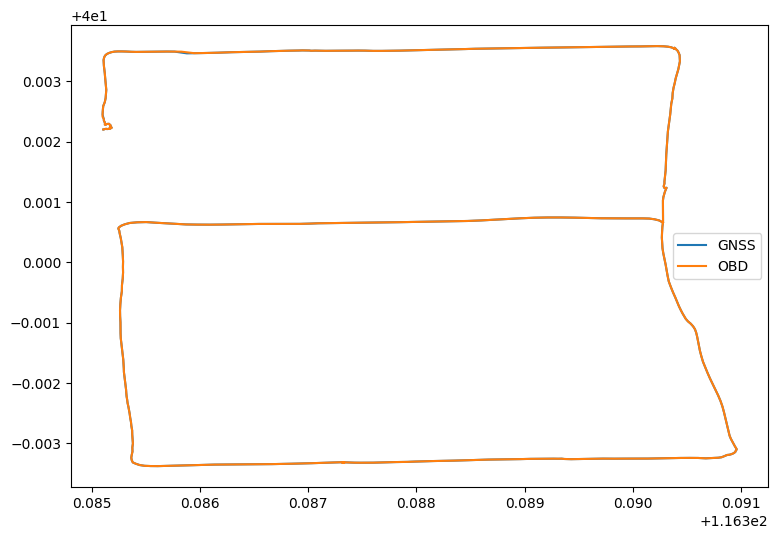

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot([u.lng for u in gnss_units[:540]], [u.lat for u in gnss_units[:540]], label='GNSS')
ax.plot([u.lng for u in obd_loc_units[:540]], [u.lat for u in obd_loc_units[:540]], label='OBD')

ax.legend()

plt.show()
plt.close()

In [11]:
gnss_dist_errs = []

for u in gnss_units:
    idx = int(u.gps_tow)
    if idx in trace_posi_unit_map:
        gt_lng = trace_posi_unit_map[idx].lng
        gt_lat = trace_posi_unit_map[idx].lat
        dist_err = geo_util.distance(gt_lng, gt_lat, u.lng, u.lat)
        gnss_dist_errs.append(dist_err)
        
print(len(gnss_dist_errs), np.percentile(gnss_dist_errs, 50), np.percentile(gnss_dist_errs, 75))

2968 3.118116 4.60239125


In [12]:
obd_dist_errs = []

for u in obd_loc_units:
    idx = int(u.gps_tow)
    if idx in trace_posi_unit_map:
        gt_lng = trace_posi_unit_map[idx].lng
        gt_lat = trace_posi_unit_map[idx].lat
        dist_err = geo_util.distance(gt_lng, gt_lat, u.lng, u.lat)
        obd_dist_errs.append(dist_err)
        
print(len(obd_dist_errs), np.percentile(obd_dist_errs, 50), np.percentile(obd_dist_errs, 75))

2968 3.119547 4.6180195


## IMU实验

In [13]:
def capture_trace_gravity(stationary_acce_units):
    Gs = [np.sqrt(np.power(u.sen_x, 2) + np.power(u.sen_y, 2) + np.power(u.sen_z, 2))
          for u in stationary_acce_units]
    G = np.percentile(Gs, 50)
    print('local gravity acceleration: %.4f' % G)

    Fs = [np.array([u.sen_x, u.sen_y, u.sen_z]) / np.linalg.norm([u.sen_x, u.sen_y, u.sen_z])
          for u in stationary_acce_units]
    Fs = np.array(Fs)
    f1 = np.sum(Fs[:, 0])
    f2 = np.sum(Fs[:, 1])
    f3 = np.sum(Fs[:, 2])

    double_lambda = np.sqrt(np.power(f1, 2) + np.power(f2, 2) + np.power(f3, 2))
    g1 = f1 / double_lambda
    g2 = f2 / double_lambda
    g3 = f3 / double_lambda
    print(g1, g2, g3)
    return g1, g2, g3, G

In [14]:
def capture_trace_acceleration(accelerated_acce_units, G1=None, G2=None, G3=None):
    r1 = np.sum([u.acc_x - G1 for u in accelerated_acce_units])
    r2 = np.sum([u.acc_y - G2 for u in accelerated_acce_units])
    r3 = np.sum([u.acc_z - G3 for u in accelerated_acce_units])

    a1 = r1 / np.sqrt(np.power(r1, 2) + np.power(r2, 2) + np.power(r3, 2))
    a2 = r2 / np.sqrt(np.power(r1, 2) + np.power(r2, 2) + np.power(r3, 2))
    a3 = r3 / np.sqrt(np.power(r1, 2) + np.power(r2, 2) + np.power(r3, 2))
    print(a1, a2, a3)
    return a1, a2, a3

In [15]:
def gen_projection_coord(stationary_acce_units, accelerated_acce_units):
    g1, g2, g3, G = capture_trace_gravity(stationary_acce_units)
    a1, a2, a3 = capture_trace_acceleration(accelerated_acce_units, G1=g1*G, G2=g2*G, G3=g3*G)
    
    Z = np.array([g1, g2, g3])
    Y = np.array([a1, a2, a3])
    X = np.cross(Y, Z)
    X = X / np.linalg.norm(X)
    print(X, Y, Z)
    return X, Y, Z

In [16]:
def project_acce(obj, X=None, Y=None, Z=None):
    prj_ax = np.dot(np.array([obj.sen_x, obj.sen_y, obj.sen_z]), X)
    prj_ay = np.dot(np.array([obj.sen_x, obj.sen_y, obj.sen_z]), Y)
    prj_az = np.dot(np.array([obj.sen_x, obj.sen_y, obj.sen_z]), Z)

    prj_obj = copy.deepcopy(obj)
    prj_obj.acc_x = prj_ax
    prj_obj.acc_y = prj_ay
    prj_obj.acc_z = prj_az

    return prj_obj


def project_gyro(obj, X=None, Y=None, Z=None):
    prj_ax = np.dot(np.array([obj.sen_x, obj.sen_y, obj.sen_z]), X)
    prj_ay = np.dot(np.array([obj.sen_x, obj.sen_y, obj.sen_z]), Y)
    prj_az = np.dot(np.array([obj.sen_x, obj.sen_y, obj.sen_z]), Z)

    prj_obj = copy.deepcopy(obj)
    prj_obj.gyr_x = prj_ax
    prj_obj.gyr_y = prj_ay
    prj_obj.gyr_z = prj_az

    return prj_obj

In [59]:
from scipy import stats


def calc_acce_drift(stationary_acce_units, X=None, Y=None, Z=None):
    if X is not None and Y is not None and Z is not None:
        stationary_prj_acce_unit = [project_acce(u, X=X, Y=Y, Z=Z) for u in stationary_acce_units]
    else:
        stationary_prj_acce_unit = stationary_acce_units
    
    prj_drift_accx = np.percentile([u.acc_x for u in stationary_prj_acce_unit], 50)
    prj_drift_accy = np.percentile([u.acc_y for u in stationary_prj_acce_unit], 50)
    prj_drift_accz = np.percentile([u.acc_z for u in stationary_prj_acce_unit], 50)
    print(prj_drift_accx, prj_drift_accy, prj_drift_accz)

    prj_drift_accx = np.mean([u.acc_x for u in stationary_prj_acce_unit])
    prj_drift_accy = np.mean([u.acc_y for u in stationary_prj_acce_unit])
    prj_drift_accz = np.mean([u.acc_z for u in stationary_prj_acce_unit])
    print(prj_drift_accx, prj_drift_accy, prj_drift_accz)
    
    return prj_drift_accx, prj_drift_accy, prj_drift_accz


def calc_gyro_drift(stationary_gyro_units, X=None, Y=None, Z=None):
    if X is not None and Y is not None and Z is not None:
        stationary_prj_gyro_unit = [project_gyro(u, X=X, Y=Y, Z=Z) for u in stationary_gyro_units]
    else:
        stationary_prj_gyro_unit = stationary_gyro_units
    
    prj_drift_gyrx = np.percentile([u.gyr_x for u in stationary_prj_gyro_unit], 50)
    prj_drift_gyry = np.percentile([u.gyr_y for u in stationary_prj_gyro_unit], 50)
    prj_drift_gyrz = np.percentile([u.gyr_z for u in stationary_prj_gyro_unit], 50)
    print(prj_drift_gyrx, prj_drift_gyry, prj_drift_gyrz)

#     prj_drift_gyrx = stats.mode([u.gyr_x for u in stationary_prj_gyro_unit], keepdims=True)[0][0]
#     prj_drift_gyry = stats.mode([u.gyr_y for u in stationary_prj_gyro_unit], keepdims=True)[0][0]
#     prj_drift_gyrz = stats.mode([u.gyr_z for u in stationary_prj_gyro_unit], keepdims=True)[0][0]
#     print(prj_drift_gyrx, prj_drift_gyry, prj_drift_gyrz)

    prj_drift_gyrx = np.mean([u.gyr_x for u in stationary_prj_gyro_unit])
    prj_drift_gyry = np.mean([u.gyr_y for u in stationary_prj_gyro_unit])
    prj_drift_gyrz = np.mean([u.gyr_z for u in stationary_prj_gyro_unit])
    print(prj_drift_gyrx, prj_drift_gyry, prj_drift_gyrz)
    
    return prj_drift_gyrx, prj_drift_gyry, prj_drift_gyrz

In [60]:
stationary_acce_units = []
stationary_gyro_units = []

segment_acce_units = []
segment_gyro_units = []

pre_obd_unit = None

for u in trace_sen_units:
    if isinstance(u, data_struct.obdUnit):
        if len(segment_acce_units) > 0 and pre_obd_unit is not None:
            if pre_obd_unit.vehicle_speed < 1e-4 and u.vehicle_speed < 1e-4:
                stationary_acce_units.extend(segment_acce_units)
                stationary_gyro_units.extend(segment_gyro_units)
        pre_obd_unit = u
        segment_acce_units = []
        segment_gyro_units = []
            
    elif isinstance(u, data_struct.acceUnit):
        segment_acce_units.append(u)
        
    elif isinstance(u, data_struct.gyroUnit):
        segment_gyro_units.append(u)
        
print(len(stationary_acce_units))
print(len(stationary_gyro_units))

280274
280270


In [61]:
calc_gyro_drift(stationary_gyro_units)

-0.0040107045659157625 0.0 -0.005729577951308233
0.0025231219786226483 -0.012397165517337367 0.0003766021515645641


(0.0025231219786226483, -0.012397165517337367, 0.0003766021515645641)

In [62]:
accelerated_acce_units = []

segment_acce_units = []

pre_gnss_unit = None

for u in trace_sen_units:
    if isinstance(u, data_struct.gnssUnit):
        if len(segment_acce_units) > 0 and pre_gnss_unit is not None:
            if pre_gnss_unit.speed - u.speed > 1.0:
                accelerated_acce_units.extend(segment_acce_units)
        pre_gnss_unit = u
        segment_acce_units = []
    
    elif isinstance(u, data_struct.acceUnit):
        segment_acce_units.append(u)

print(len(accelerated_acce_units))

34773


In [63]:
X, Y, Z = gen_projection_coord(stationary_acce_units, accelerated_acce_units)

acce_drift = calc_acce_drift(stationary_acce_units, X=X, Y=Y, Z=Z)
gyro_drift = calc_gyro_drift(stationary_gyro_units, X=X, Y=Y, Z=Z)

local gravity acceleration: 9.7729
-0.004625692971775965 0.961952077104217 0.27317907006103787
-0.01773260960794555 -0.2678685981935665 0.9632922550598576
[-9.99832515e-01  3.88289583e-04 -1.82972810e-02] [-0.01773261 -0.2678686   0.96329226] [-0.00462569  0.96195208  0.27317907]
0.003174052930054551 0.06431939105769646 9.771021351422458
-0.00015407714218753198 0.054283966428103465 9.769549110515735
0.004015428263026269 -0.0017189020667590176 -0.00032083975943054683
-0.002534403880026866 0.003638847747503661 -0.011834270481663509


In [67]:
def acce_mean_filter(acce_units, alpha=0.8):
    filtered_acce_units = []
    for u in acce_units:
        if len(filtered_acce_units) == 0:
            filtered_acce_units.append(u)
        else:
            unit = copy.deepcopy(u)
            unit.acc_x = filtered_acce_units[-1].acc_x * alpha + u.acc_x * (1 - alpha)
            unit.acc_y = filtered_acce_units[-1].acc_y * alpha + u.acc_y * (1 - alpha)
            unit.acc_z = filtered_acce_units[-1].acc_z * alpha + u.acc_z * (1 - alpha)
            filtered_acce_units.append(unit)
    return filtered_acce_units


def gyro_mean_filter(gyro_units, alpha=0.8):
    filtered_gyro_units = []
    for u in gyro_units:
        if len(filtered_gyro_units) == 0:
            filtered_gyro_units.append(u)
        else:
            unit = copy.deepcopy(u)
            unit.gyr_x = filtered_gyro_units[-1].gyr_x * alpha + u.gyr_x * (1 - alpha)
            unit.gyr_y = filtered_gyro_units[-1].gyr_y * alpha + u.gyr_y * (1 - alpha)
            unit.gyr_z = filtered_gyro_units[-1].gyr_z * alpha + u.gyr_z * (1 - alpha)
            filtered_gyro_units.append(unit)
    return filtered_gyro_units


def infer_sec_spd_via_imu(crnt_spd, sec_acce_units, drift=0.0, X=None, Y=None, Z=None):
#     sec_acce_units = acce_mean_filter(sec_acce_units)
    sec_prj_acce_units = [project_acce(u, X=X, Y=Y, Z=Z) for u in sec_acce_units]
    ys = [(u.sen_y - drift) for u in sec_prj_acce_units]
#     ys = [u.sen_z - 9.7729 * 0.27317907006103787 for u in sec_acce_units]
    diff_spd = np.sum(ys) / len(ys) * -1.0
    return crnt_spd + diff_spd


def infer_sec_brng_via_imu(crnt_brng, sec_gyro_units, drift=0.0, X=None, Y=None, Z=None):
    sec_gyro_units = gyro_mean_filter(sec_gyro_units)
    sec_prj_gyro_units = [project_gyro(u, X=X, Y=Y, Z=Z) for u in sec_gyro_units]
    zs = [(u.sen_z - drift) for u in sec_prj_gyro_units]
#     zs = [() for u in sec_gyro_units]
    diff_brng = np.sum(zs) / len(zs) * -1.0
    return (crnt_brng + diff_brng) % 360


gnss_units = []

acce_spds = []
gyro_brngs = []

sec_acce_units = []
sec_gyro_units = []

for u in trace_sen_units[60000:]:
    if isinstance(u, data_struct.gnssUnit):
        if len(gnss_units) == 0 and len(acce_spds) == 0:
            gnss_units.append(u)
            acce_spds.append(u.speed)
            gyro_brngs.append(u.bearing)
            continue
            
        if len(sec_acce_units) > 250 * 60:
            break
            
        if 200 < len(sec_acce_units) < 300:
            next_spd = infer_sec_spd_via_imu(acce_spds[-1], sec_acce_units, drift=acce_drift[1] * 1, X=X, Y=Y, Z=Z)
            acce_spds.append(next_spd)
            
        if 200 < len(sec_gyro_units) < 300:
            next_brng = infer_sec_brng_via_imu(gyro_brngs[-1], sec_gyro_units, drift=gyro_drift[2], X=X, Y=Y, Z=Z)
            gyro_brngs.append(next_brng)
        
        gnss_units.append(u)
        sec_acce_units = []
        sec_gyro_units = []
        
    elif isinstance(u, data_struct.acceUnit):
        sec_acce_units.append(u)
    
    elif isinstance(u, data_struct.gyroUnit):
        sec_gyro_units.append(u)
        
print(len(gnss_units), len(acce_spds), len(gyro_brngs))


891 891 891


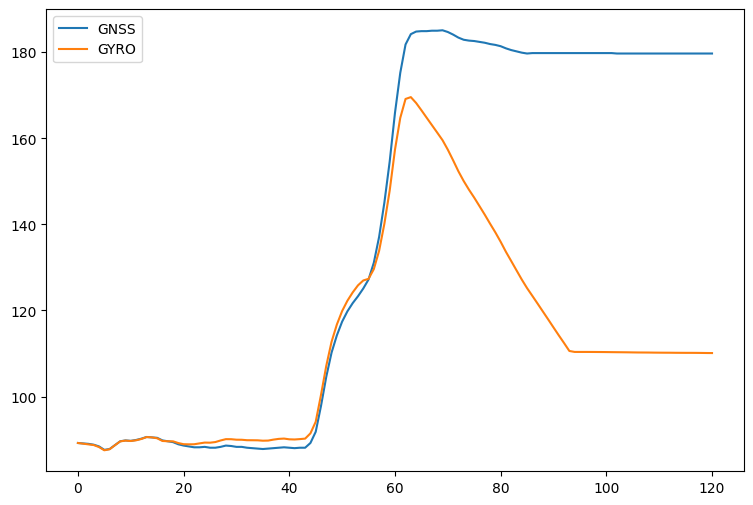

In [68]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot([u.bearing for u in gnss_units[:121]], label='GNSS')
ax.plot(gyro_brngs[:121], label='GYRO')

ax.legend()

plt.show()
plt.close()

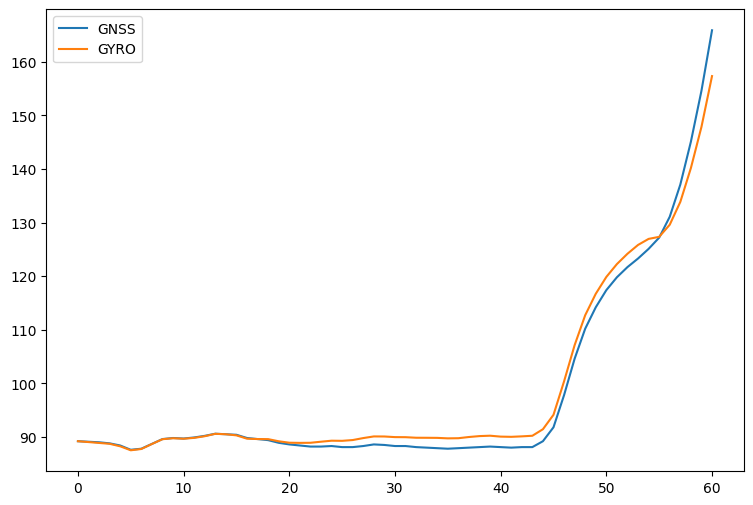

In [69]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot([u.bearing for u in gnss_units[:61]], label='GNSS')
ax.plot(gyro_brngs[:61], label='GYRO')

ax.legend()

plt.show()
plt.close()

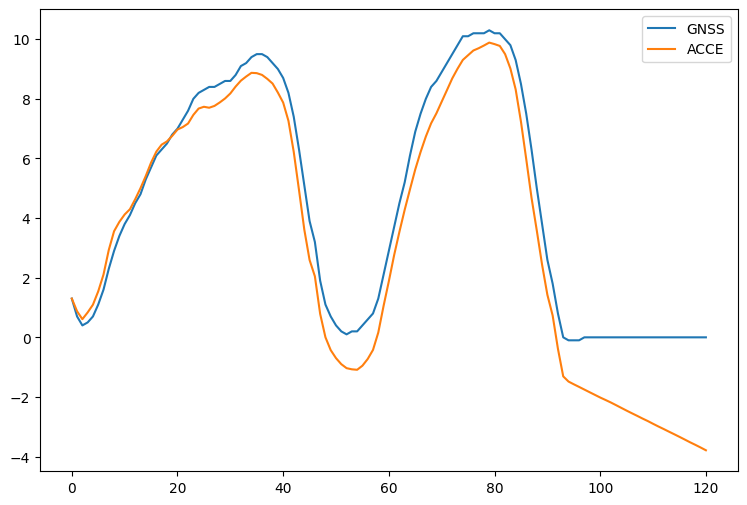

In [70]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot([u.speed for u in gnss_units[:121]], label='GNSS')
ax.plot(acce_spds[:121], label='ACCE')

# ax.set_ylim(-2, 15)

ax.legend()

plt.show()
plt.close()

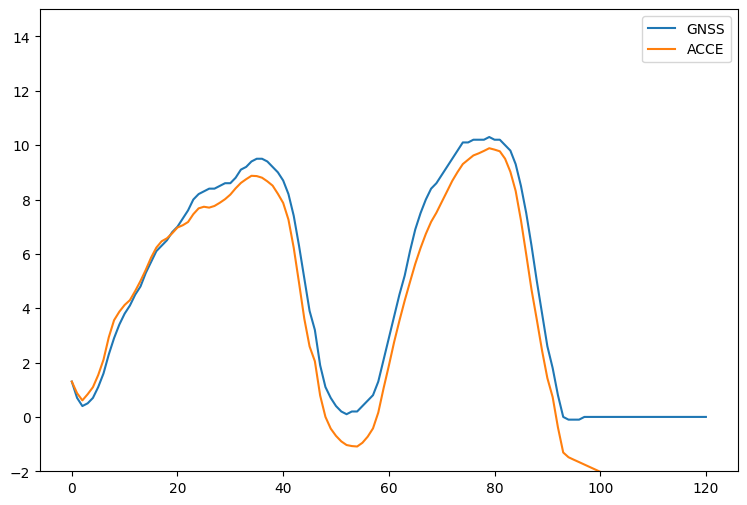

In [71]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot([u.speed for u in gnss_units[:121]], label='GNSS')
ax.plot(acce_spds[:121], label='ACCE')

ax.set_ylim(-2, 15)

ax.legend()

plt.show()
plt.close()